# Gravitational orbit in Cartesian coordinates

Defines an Orbit class that is used to generate basic trajectory plots for two bodies by solving Lagrange's equations.

Created by Yuqi Wang (wang.8615@osu.edu).

## Euler-Lagrange equation

For two bodies, the Lagrangian with generalized coordinate $x_1$, $x_2$, $y_1$, $y_2$ are

$\begin{align}
  \mathcal{L} = T-U = \frac12 m_1 (\dot x_1^2+\dot y_2^2)+\frac12 m_2 (\dot x_2^2+\dot y_2^2)+\frac {G m_1 m_2} {\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}}
\end{align}$

The Euler-Lagrange equations are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_1} = \frac{\partial\mathcal L}{\partial x_1}
 \quad\Longrightarrow\quad
 m_1 \ddot x_1 = \frac {-G m_1 m_2 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_2} = \frac{\partial\mathcal L}{\partial x_2}
 \quad\Longrightarrow\quad
 m_2 \ddot x_2 = \frac { G m_1 m_2 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_1} = \frac{\partial\mathcal L}{\partial y_1}
 \quad\Longrightarrow\quad
 m_1 \ddot y_1 = \frac {-G m_1 m_2 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_2} = \frac{\partial\mathcal L}{\partial y_2}
 \quad\Longrightarrow\quad
 m_2 \ddot y_2 = \frac { G m_1 m_2 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}
 \;
\end{align}$

Finally solve for $\ddot x_1$, $\ddot x_2$, $\ddot y_1$, $\ddot y_2$

$\begin{align}
 \ddot x_1 = \frac {-G m_2 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \ddot x_2 = \frac { G m_1 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \ddot y_1 = \frac {-G m_2 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \ddot y_2 = \frac { G m_1 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}
 \;
\end{align}$


In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Orbit class and utility functions

In [4]:
class Orbit():
    """
    Pendulum class implements the parameters and Lagranges's equations for 
     double pendulum (no driving or damping).
     
    Parameters
    ----------
    G : float
        Universal gravitational constant
    mass1 : float
        mass of the first body
    mass2 : float
        mass of the second body

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, mass1=1.,mass2=1., G=1. 
                ):
        self.G = G
        self.mass1 = mass1
        self.mass2 = mass2

    def dy_dt(self, t, y):
        
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dx2/dt d^2x2/dt^2 dy1/dt d^2y1/dt^2 dy2/dt d^2y2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 8-component vector with 
            y[0] = x1(t) and y[1] = dx1/dt
            y[2] = x2(t) and y[3] = dx2/dt
            y[4] = y1(t) and y[5] = dy1/dt
            y[6] = y2(t) and y[7] = dy2/dt         
        Returns
        -------
        
        """
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot= y
        cmultiplier = self.G*self.mass1*self.mass2*((x1-x2)**2+(y1-y2)**2)**(-3/2)
        x1_double_dot = -cmultiplier*(x1-x2)/self.mass1
        x2_double_dot = cmultiplier*(x1-x2)/self.mass2
        y1_double_dot = -cmultiplier*(y1-y2)/self.mass1
        y2_double_dot = cmultiplier*(y1-y2)/self.mass2
        
        return x1_dot, x1_double_dot, x2_dot, x2_double_dot, y1_dot, y1_double_dot, y2_dot, y2_double_dot
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = solution.y

        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Part (a) : Make trajectory plots

In [7]:
# Labels for individual plot axes
trajectory_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 2.5
mass1 = 1.
mass2 = 1.

# Instantiate two bodies
o1 = Orbit(mass1=mass1, mass2=mass2, G=G)

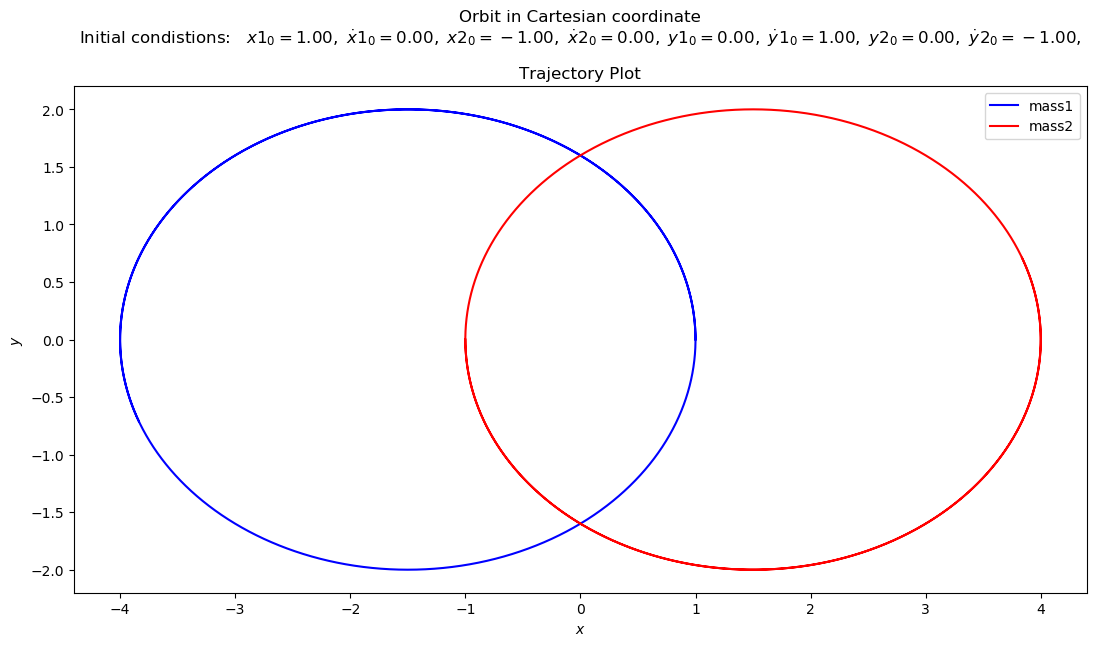

In [8]:
x1_0 = 1.
x1_dot_0 = 0
x2_0 = -1.
x2_dot_0 = 0
y1_0 = 0
y1_dot_0 = 1.
y2_0 = 0
y2_dot_0 = -1.

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = o1.solve_ode(t_pts, \
                                                              x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                              y1_0, y1_dot_0, y2_0, y2_dot_0)

# start the plot!

fig = plt.figure(figsize=(15,6))

overall_title = 'Orbit in Cartesian coordinate' + \
                '\n' + \
                'Initial condistions:  ' + \
                rf' $x1_0 = {x1_0:.2f},$' + \
                rf' $\dot x1_0 = {x1_dot_0:.2f},$' + \
                rf' $x2_0 = {x2_0:.2f},$' + \
                rf' $\dot x2_0 = {x2_dot_0:.2f},$' + \
                rf' $y1_0 = {y1_0:.2f},$' + \
                rf' $\dot y1_0 = {y1_dot_0:.2f},$' + \
                rf' $y2_0 = {y2_0:.2f},$' + \
                rf' $\dot y2_0 = {y2_dot_0:.2f},$' + \
                '\n'     #\n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# trajectory plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=trajectory_labels, 
            color='blue',
            label='mass1', 
            title='Trajectory Plot',
            ax=ax_a)  

plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=trajectory_labels,
            color='red',
            label='mass2',
            ax=ax_a)  

ax_a.set_aspect(1)
fig.tight_layout()
fig.savefig('orbit_trajectory.pdf', bbox_inches='tight')  

## Part (b) : Heavy mass

In [9]:
# Labels for individual plot axes
trajectory_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 10.
mass1 = 1.
mass2 = 10000.

# Instantiate two bodies
o1 = Orbit(mass1=mass1, mass2=mass2, G=G)


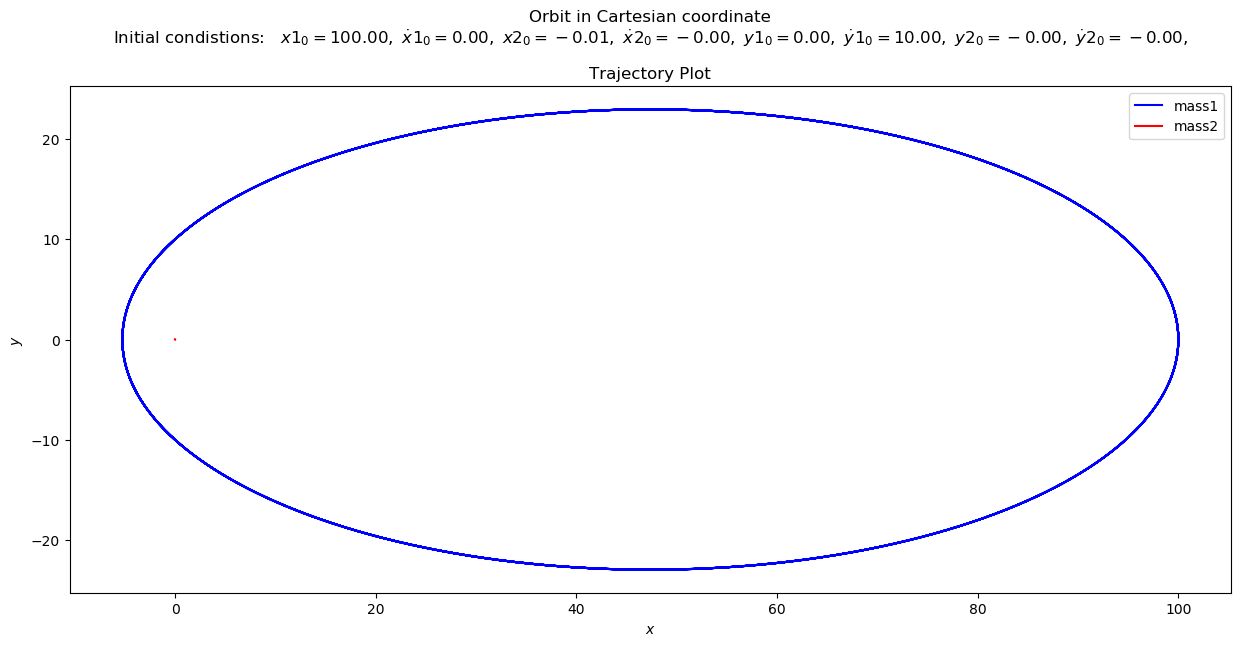

In [10]:
x1_0 = 100.
x1_dot_0 = 0
x2_0 = mass1*x1_0/(-mass2)
x2_dot_0 = mass1*x1_dot_0/(-mass2)
y1_0 = 0
y1_dot_0 = 10.
y2_0 = mass1*y1_0/(-mass2)
y2_dot_0 = mass1*y1_dot_0/(-mass2)

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = o1.solve_ode(t_pts, \
                                                                 x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                                 y1_0, y1_dot_0, y2_0, y2_dot_0)
# start the plot!

fig = plt.figure(figsize=(15,6))

overall_title = 'Orbit in Cartesian coordinate' + \
                '\n' + \
                'Initial condistions:  ' + \
                rf' $x1_0 = {x1_0:.2f},$' + \
                rf' $\dot x1_0 = {x1_dot_0:.2f},$' + \
                rf' $x2_0 = {x2_0:.2f},$' + \
                rf' $\dot x2_0 = {x2_dot_0:.2f},$' + \
                rf' $y1_0 = {y1_0:.2f},$' + \
                rf' $\dot y1_0 = {y1_dot_0:.2f},$' + \
                rf' $y2_0 = {y2_0:.2f},$' + \
                rf' $\dot y2_0 = {y2_dot_0:.2f},$' + \
                '\n'     #\n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# trajectory plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=trajectory_labels, 
            color='blue',
            label='mass1', 
            title='Trajectory Plot',
            ax=ax_a)  

plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=trajectory_labels,
            color='red',
            label='mass2', 
            ax=ax_a)  

ax_a.set_aspect(1)
fig.tight_layout()
fig.savefig('orbit_heavy_mass.pdf', bbox_inches='tight')  

## Part (d) : Solving differential equation using the leapfrog method

In [11]:
class Orbit_Leapfrog():
    """
    Pendulum class implements the parameters and Lagranges's equations for 
     double pendulum (no driving or damping).
     
    Parameters
    ----------
    G : float
        Universal gravitational constant
    mass1 : float
        mass of the first body
    mass2 : float
        mass of the second body

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, mass1=1.,mass2=1., G=1. 
                ):
        self.G = G
        self.mass1 = mass1
        self.mass2 = mass2

    def dy_dt(self, t, y):
        
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dx2/dt d^2x2/dt^2 dy1/dt d^2y1/dt^2 dy2/dt d^2y2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 8-component vector with 
            y[0] = x1(t) and y[1] = dx1/dt
            y[2] = x2(t) and y[3] = dx2/dt
            y[4] = y1(t) and y[5] = dy1/dt
            y[6] = y2(t) and y[7] = dy2/dt         
        Returns
        -------
        
        """
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = y
        cmultiplier = self.G*self.mass1*self.mass2*((x1-x2)**2+(y1-y2)**2)**(-3/2)
        x1_double_dot = -cmultiplier*(x1-x2)/self.mass1
        x2_double_dot = cmultiplier*(x1-x2)/self.mass2
        y1_double_dot = -cmultiplier*(y1-y2)/self.mass1
        y2_double_dot = cmultiplier*(y1-y2)/self.mass2
        
        return x1_dot, x1_double_dot, x2_dot, x2_double_dot, y1_dot, y1_double_dot, y2_dot, y2_double_dot
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = solution.y

        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot

    def solve_ode_Leapfrog(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for x1, x1_dot, x1_dot_half, x2, x2_dot, x2_dot_half, 
        # y1, y1_dot, y1_dot_half, y2, y2_dot, y2_dot_half, with zeros
        
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], x1_dot[i], x2[i], x2_dot[i], y1[i], y1_dot[i], y2[i], y2_dot[i]]
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            
            y = [x1[i+1], x1_dot[i], x2[i+1], x2_dot[i], y1[i+1], y1_dot[i], y2[i+1], y2_dot[i]]
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.           
           
        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot
        
    
    def energy(self, x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot):
        distance = np.sqrt((x1-x2)**2+(y1-y2)**2)
        KE = 0.5*self.mass1*(x1_dot**2+y1_dot**2)+0.5*self.mass2*(x2_dot**2+y2_dot**2)
        PE = -self.G*self.mass1*self.mass2/distance
        return KE + PE

In [12]:
# Labels for individual plot axes
trajectory_labels = (r'$x$', r'$y$')
energy_labels = (r'$time$', r'$energy$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 5
mass1 = 1.
mass2 = 1.

# Instantiate two body
o1 = Orbit_Leapfrog(mass1=mass1, mass2=mass2, G=G)

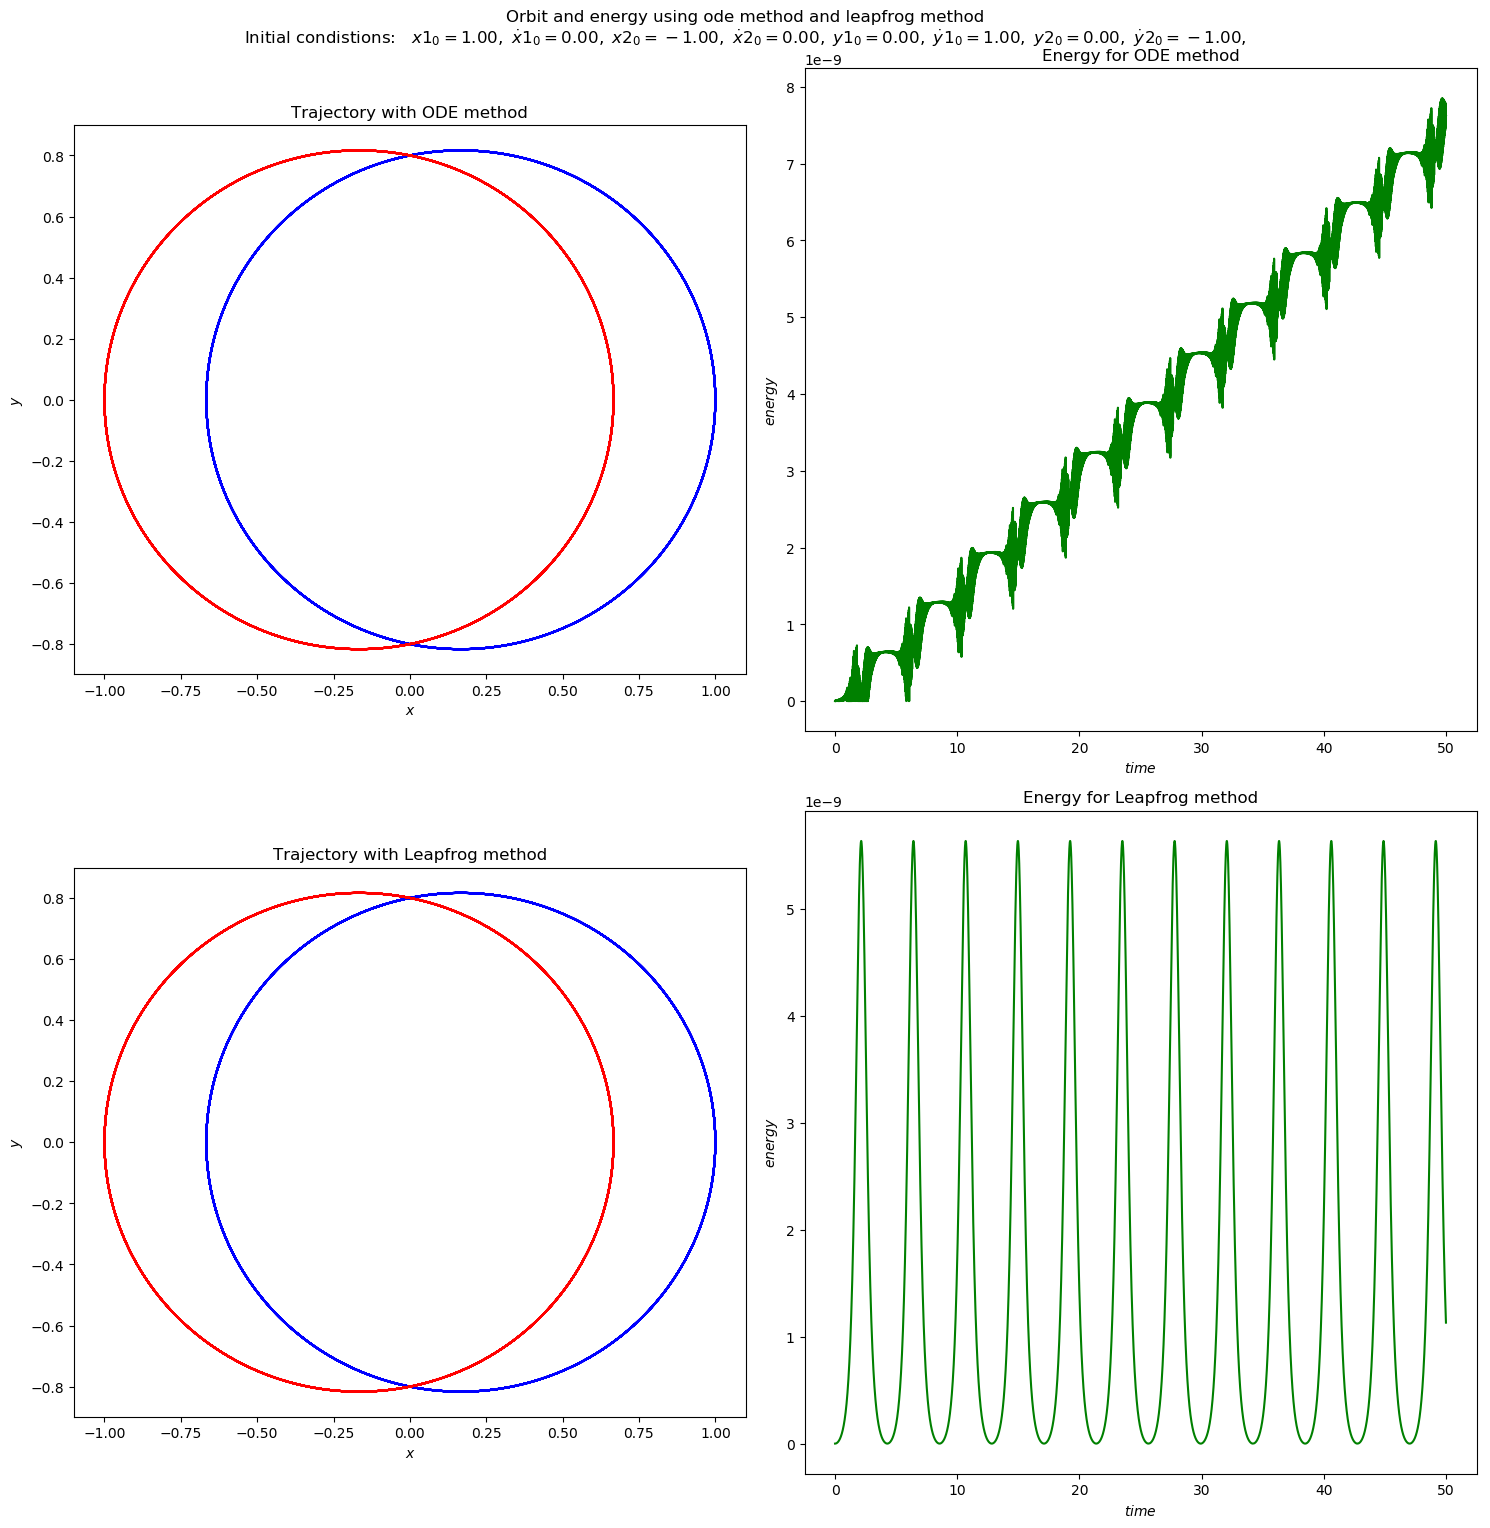

In [13]:
x1_0 = 1
x1_dot_0 = 0
x2_0 = -1
x2_dot_0 = 0
y1_0 = 0
y1_dot_0 = 1
y2_0 = 0
y2_dot_0 = -1

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = o1.solve_ode(t_pts, \
                                                              x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                              y1_0, y1_dot_0, y2_0, y2_dot_0)

x1_LF, x1_dot_LF, x2_LF, x2_dot_LF, y1_LF, y1_dot_LF, y2_LF, y2_dot_LF = o1.solve_ode_Leapfrog(t_pts, \
                                                              x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                              y1_0, y1_dot_0, y2_0, y2_dot_0)

E_tot_pts = o1.energy(x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_LF = o1.energy(x1_LF, x1_dot_LF, x2_LF, x2_dot_LF, y1_LF, y1_dot_LF, y2_LF, y2_dot_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

# start the plot!

fig = plt.figure(figsize=(15,15))

overall_title = 'Orbit and energy using ode method and leapfrog method' + \
                '\n' + \
                'Initial condistions:  ' + \
                rf' $x1_0 = {x1_0:.2f},$' + \
                rf' $\dot x1_0 = {x1_dot_0:.2f},$' + \
                rf' $x2_0 = {x2_0:.2f},$' + \
                rf' $\dot x2_0 = {x2_dot_0:.2f},$' + \
                rf' $y1_0 = {y1_0:.2f},$' + \
                rf' $\dot y1_0 = {y1_dot_0:.2f},$' + \
                rf' $y2_0 = {y2_0:.2f},$' + \
                rf' $\dot y2_0 = {y2_dot_0:.2f},$' + \
                '\n'     #\n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# trajectory plot 
ax_a = fig.add_subplot(2,2,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=trajectory_labels, 
            color='blue',
            label=None, 
            title='Trajectory with ODE method', 
            ax=ax_a)  

plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=trajectory_labels,
            color='red',
            label=None,
            ax=ax_a)  

ax_b = fig.add_subplot(2,2,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], E_tot_rel_pts[start : stop], 
            axis_labels=energy_labels, 
            color='green',
            label=None, 
            title='Energy for ODE method', 
            ax=ax_b)  


ax_c = fig.add_subplot(2,2,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_LF[start : stop], y1_LF[start : stop], 
            axis_labels=trajectory_labels, 
            color='blue',
            label=None, 
            title='Trajectory with Leapfrog method', 
            ax=ax_c)  

plot_y_vs_x(x2_LF[start : stop], y2_LF[start : stop], 
            axis_labels=trajectory_labels,
            color='red',
            label=None,
            ax=ax_c)  

ax_d = fig.add_subplot(2,2,4)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], E_tot_rel_pts_LF[start : stop], 
            axis_labels=energy_labels, 
            color='green',
            label=None, 
            title='Energy for Leapfrog method', 
            ax=ax_d)  



ax_a.set_aspect(1)
ax_c.set_aspect(1)
fig.tight_layout()
fig.savefig('orbit_energy_ode_and_LF.pdf', bbox_inches='tight')  

## Part (e) : Three bodies

In [14]:
class Three_body_Orbit():
    """
    Pendulum class implements the parameters and Lagranges's equations for 
     double pendulum (no driving or damping).
     
    Parameters
    ----------
    G : float
        Universal gravitational constant
    mass1 : float
        mass of the first body
    mass2 : float
        mass of the second body
    mass3 : float
        mass of the third body

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, mass1=1.,mass2=1., mass3=1., G=1. 
                ):
        self.G = G
        self.mass1 = mass1
        self.mass2 = mass2
        self.mass3 = mass3

    def dy_dt(self, t, y):
        
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dx2/dt d^2x2/dt^2 dx3/dt d^2x3/dt^2
         dy1/dt d^2y1/dt^2 dy2/dt d^2y2/dt^2 dy3/dt d^2y3/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 8-component vector with 
            y[0] = x1(t) and y[1] = dx1/dt
            y[2] = x2(t) and y[3] = dx2/dt
            y[4] = x3(t) and y[5] = dx3/dt
            y[6] = y1(t) and y[7] = dy1/dt
            y[8] = y2(t) and y[9] = dy2/dt    
            y[10] = y3(t) and y[11] = dy3/dt   
        Returns
        -------
        
        """
        x1, x1_dot, x2, x2_dot, x3, x3_dot, y1, y1_dot, y2, y2_dot, y3, y3_dot = y
        cmultiplier1 = self.G*self.mass1*self.mass2*((x1-x2)**2+(y1-y2)**2)**(-3/2)
        cmultiplier2 = self.G*self.mass1*self.mass3*((x1-x3)**2+(y1-y3)**2)**(-3/2)
        cmultiplier3 = self.G*self.mass2*self.mass3*((x2-x3)**2+(y2-y3)**2)**(-3/2)
        x1_double_dot = (-cmultiplier1*(x1-x2)-cmultiplier2*(x1-x3))/self.mass1
        x2_double_dot = (cmultiplier1*(x1-x2)-cmultiplier3*(x2-x3))/self.mass2
        x3_double_dot = (cmultiplier2*(x1-x3)+cmultiplier3*(x2-x3))/self.mass3
        y1_double_dot = (-cmultiplier1*(y1-y2)-cmultiplier2*(y1-y3))/self.mass1
        y2_double_dot = (cmultiplier1*(y1-y2)-cmultiplier3*(y2-y3))/self.mass2
        y3_double_dot = (cmultiplier2*(y1-y3)+cmultiplier3*(y2-y3))/self.mass3
        
        return x1_dot, x1_double_dot, x2_dot, x2_double_dot, x3_dot, x3_double_dot,\
               y1_dot, y1_double_dot, y2_dot, y2_double_dot, y3_dot, y3_double_dot
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, x3_0, x3_dot_0,
                  y1_0, y1_dot_0, y2_0, y2_dot_0, y3_0, y3_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, x2_0, x2_dot_0, x3_0, x3_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0, y3_0, y3_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, x2, x2_dot, x3, x3_dot, y1, y1_dot, y2, y2_dot, y3, y3_dot = solution.y

        return x1, x1_dot, x2, x2_dot, x3, x3_dot, y1, y1_dot, y2, y2_dot, y3, y3_dot

In [15]:
# Labels for individual plot axes
trajectory_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 1
mass1 = 100.
mass2 = 1.
mass3 = 1.

# Instantiate three bodies
o1 = Three_body_Orbit(mass1=mass1, mass2=mass2, mass3=mass3, G=G)

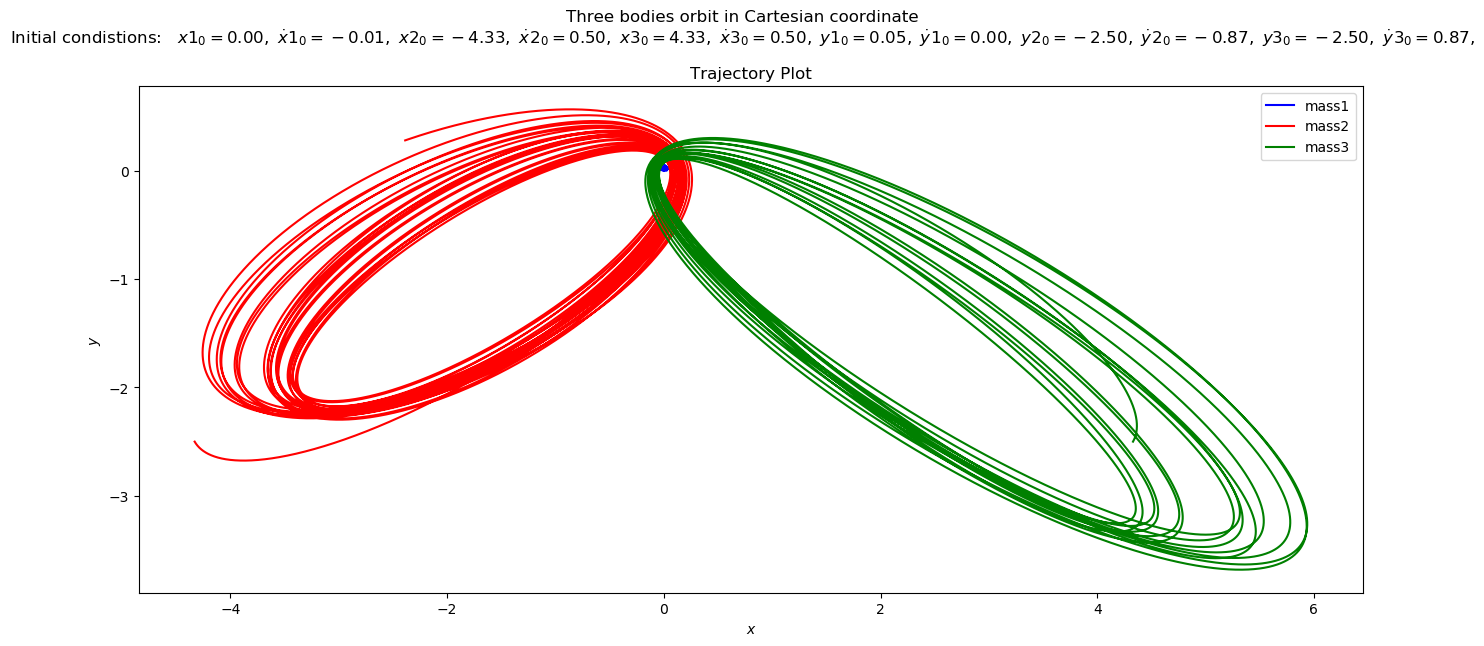

In [16]:
x1_0 = 0
x1_dot_0 = -0.01
x2_0 = -5*np.sqrt(3.)/2.
x2_dot_0 = 0.5
x3_0 = 5*np.sqrt(3.)/2.
x3_dot_0 = 0.5
y1_0 = 0.05
y1_dot_0 = 0.
y2_0 = -2.5
y2_dot_0 = -np.sqrt(3.)/2.
y3_0 = -2.5
y3_dot_0 = np.sqrt(3.)/2.

x1, x1_dot, x2, x2_dot, x3, x3_dot, y1, y1_dot, y2, y2_dot, y3, y3_dot = o1.solve_ode(t_pts, \
                                                              x1_0, x1_dot_0, x2_0, x2_dot_0, x3_0, x3_dot_0, \
                                                              y1_0, y1_dot_0, y2_0, y2_dot_0, y3_0, y3_dot_0)

# start the plot!

fig = plt.figure(figsize=(15,6))

overall_title = 'Three bodies orbit in Cartesian coordinate' + \
                '\n' + \
                'Initial condistions:  ' + \
                rf' $x1_0 = {x1_0:.2f},$' + \
                rf' $\dot x1_0 = {x1_dot_0:.2f},$' + \
                rf' $x2_0 = {x2_0:.2f},$' + \
                rf' $\dot x2_0 = {x2_dot_0:.2f},$' + \
                rf' $x3_0 = {x3_0:.2f},$' + \
                rf' $\dot x3_0 = {x3_dot_0:.2f},$' + \
                rf' $y1_0 = {y1_0:.2f},$' + \
                rf' $\dot y1_0 = {y1_dot_0:.2f},$' + \
                rf' $y2_0 = {y2_0:.2f},$' + \
                rf' $\dot y2_0 = {y2_dot_0:.2f},$' + \
                rf' $y3_0 = {y3_0:.2f},$' + \
                rf' $\dot y3_0 = {y3_dot_0:.2f},$' + \
                '\n'     #\n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# trajectory plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=trajectory_labels, 
            color='blue',
            label='mass1',  
            title='Trajectory Plot',
            ax=ax_a)  

plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=trajectory_labels,
            color='red',
            label='mass2', 
            ax=ax_a)  

plot_y_vs_x(x3[start : stop], y3[start : stop], 
            axis_labels=trajectory_labels,
            color='green',
            label='mass3', 
            ax=ax_a)  

ax_a.set_aspect(1)
fig.tight_layout()
fig.savefig('orbit_three_masses.pdf', bbox_inches='tight')  

## Part (f) : Widgets

In [17]:
# Import explicitly the widgets we might use (add more as needed!) 
import ipywidgets as widgets
from ipywidgets import interact, HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display

In [18]:
def my_function1(x1_0 = 1., x1_dot_0 = 0, y1_0 = 0, y1_dot_0 = 1., \
                 G=1.0, mass1=1., mass2=1.):
    t_start = 0.
    t_end = 50.
    delta_t = 0.001

    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    # Instantiate a orbit 
    o1 = Orbit(mass1=mass1, mass2=mass2, G=G)

    x2_0 = mass1*x1_0/(-mass2)
    x2_dot_0 = mass1*x1_dot_0/(-mass2)
    y2_0 = mass1*y1_0/(-mass2)
    y2_dot_0 = mass1*y1_dot_0/(-mass2)
    x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = o1.solve_ode(t_pts, \
                                                                     x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                                     y1_0, y1_dot_0, y2_0, y2_dot_0)
    return y1

def my_function2(x1_0 = 1., x1_dot_0 = 0, y1_0 = 0, y1_dot_0 = 1., \
                 G=1.0, mass1=1., mass2=1.):
    t_start = 0.
    t_end = 50.
    delta_t = 0.001

    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    # Instantiate a orbit 
    o1 = Orbit(mass1=mass1, mass2=mass2, G=G)

    x2_0 = mass1*x1_0/(-mass2)
    x2_dot_0 = mass1*x1_dot_0/(-mass2)
    y2_0 = mass1*y1_0/(-mass2)
    y2_dot_0 = mass1*y1_dot_0/(-mass2)
    x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = o1.solve_ode(t_pts, \
                                                                     x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                                     y1_0, y1_dot_0, y2_0, y2_dot_0)
    return y2

def orbit_plot(x1_0 = 1., x1_dot_0 = 0, y1_0 = 0, y1_dot_0 = 1., \
               G=1.0, mass1=1., mass2=1.):

    t_start = 0.
    t_end = 50.
    delta_t = 0.001

    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    # Instantiate a orbit 
    o1 = Orbit(mass1=mass1, mass2=mass2, G=G)

    x2_0 = mass1*x1_0/(-mass2)
    x2_dot_0 = mass1*x1_dot_0/(-mass2)
    y2_0 = mass1*y1_0/(-mass2)
    y2_dot_0 = mass1*y1_dot_0/(-mass2)
    x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = o1.solve_ode(t_pts, \
                                                                     x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                                     y1_0, y1_dot_0, y2_0, y2_dot_0)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line, = ax.plot(x1, my_function1(x1_0=x1_0, x1_dot_0=x1_dot_0, y1_0=y1_0, y1_dot_0=y1_dot_0, \
                                     G=G, mass1 = mass1, mass2 = mass2),
                    lw=2, color='blue', label='mass1', )
    line, = ax.plot(x1, my_function2(x1_0=x1_0, x1_dot_0=x1_dot_0, y1_0=y1_0, y1_dot_0=y1_dot_0, \
                                     G=G, mass1 = mass1, mass2 = mass2),
                    lw=2, color='red', label='mass2', )
    ax.set_aspect(1)
    ax.legend()
    

In [19]:
x1_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$x1_0$ :', continuous_update=False)
x1_dot_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\dot x1_0$ :', continuous_update=False)
y1_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$y1_0$ :', continuous_update=False)
y1_dot_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\dot y1_0$ :', continuous_update=False)
G_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$G$ :', continuous_update=False)
mass1_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$mass1$ :', continuous_update=False)
mass2_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$mass2$ :', continuous_update=False)

In [20]:
plot_out = widgets.interactive_output(orbit_plot,
                                      dict(
                                      x1_0=x1_0_w,
                                      x1_dot_0=x1_dot_0_w,
                                      y1_0=y1_0_w,
                                      y1_dot_0=y1_dot_0_w,
                                      G=G_w,
                                      mass1=mass1_w,
                                      mass2=mass2_w,
                                      )
                                     )

In [21]:
hbox1 = HBox([x1_0_w, x1_dot_0_w])
hbox2 = HBox([y1_0_w, y1_dot_0_w])
hbox3 = HBox([mass1_w, mass2_w])
hbox4 = HBox([G_w])
UI_box = VBox([hbox1, hbox2, hbox3, hbox4, plot_out])

In [22]:
display(UI_box)